<a href="https://colab.research.google.com/github/Lalasa1234/CyberbullyingDetection/blob/main/CybertextBullying_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install transformers accelerate evaluate datasets
#safetensor contains model state and is faster and safer than pickle

In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import matplotlib.pyplot as plt
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import accelerate # simplifies training in PyTorch
import torch
import evaluate
from datasets import Dataset # to convert dataframe to dataset and leverage its computational functions

In [3]:
#from google.colab import drive
#drive.mount('/content/drive',force_remount = True)

In [4]:
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'
print (device)

cpu


In [5]:
#import huggingface_hub # to download or upload repos into HuggingFace
#from huggingface_hub import notebook_login
#notebook_login() # access token created in HF, token enables you to create apps on HF

In [6]:
df = pd.read_csv('../datasets/CyberbullyingTypesDataset.csv', encoding='ISO-8859-1')

### *EDA and Pre-Processing*

In [7]:
df.head()

,Tweet,Class
0,Post-Cuomo push to toughen NY sexual harassmen...,Sexual Harassment
1,Push to toughen NY sexual harassment laws that...,Sexual Harassment
2,@GabbieHanna As if Trisha didnât accuse him ...,Sexual Harassment
3,@fentsemadii True is that ð¥ thou I know not...,Sexual Harassment
4,Watch the recap video of the two-day hands-on ...,Sexual Harassment


In [8]:
df['Class'].unique()

array(['Sexual Harassment', 'Cyberstalking', 'Doxing', 'Revenge Porn',
       'Slut Shaming'], dtype=object)

In [9]:
#df['cyberbullying_type'][np.where(df['cyberbullying_type'] == 'other_cyberbullying')[0]].unique()

*Remove columns not necessary for text classification problem*

1. Remove ID columns like index, id
2. All values of 'none' annotation values correspond to 0 oh_label, our objective is to classify text as toxic or not, hence removing annotation

In [10]:
#df.drop(columns = ['index','id','Annotation'],inplace=True)

*Null value imputation*
1. Remove the Text that has null value
2. If text is relevant, manually de-nullify the oh-label

In [11]:
df.isnull().sum()

Tweet    0
Class    0
dtype: int64

In [12]:
df[pd.isnull(df['Tweet'])]

,Tweet,Class


In [13]:
#df.drop(index = [2993], inplace = True)

In [14]:
#df[pd.isnull(df['oh_label'])]

In [15]:
#df['oh_label'][2992] = 1
#df.drop(index = [2994],inplace=True)

In [16]:
#df.isnull().sum()

In [17]:
df.shape

(2140, 2)

In [18]:
#df = df[df["label"]!="none"]

In [20]:
#df['label'] = df['label'].astype('int') # this is necessary to debug the error that will be thrown by BCELogitswithLoss
#df

# Option 2: Drop rows with invalid 'label' values
#df = df[df['label'].isin(['none'])]
#df = df[df['label'].isin(['0', '1'])]
#
# Map the 'label' to integer values (0 or 1)
#df['label'] = df['label'].map({'L':0, 'M':1, 'H':2})
#df['label'] = df['label'].map({'0': 0, '0': 1})

# Convert the 'label' column to int
#df['label'] = df['label'].astype('int')

# Filter out rows where label is 'none'
#df = df[df['cyberbullying_type'] != 'other_cyberbullying']

# Encode labels to numeric values
label_mapping = {'Sexual Harassment': 0, 'Cyberstalking': 1, 'Doxing': 2, 'Revenge Porn':3, 'Slut Shaming':4}
df['Class'] = df['Class'].map(label_mapping)

df     

,Tweet,Class
0,Post-Cuomo push to toughen NY sexual harassmen...,0
1,Push to toughen NY sexual harassment laws that...,0
2,@GabbieHanna As if Trisha didnât accuse him ...,0
3,@fentsemadii True is that ð¥ thou I know not...,0
4,Watch the recap video of the two-day hands-on ...,0
...,...,...
2135,@missmayim @Jeopardy A travesty that they chos...,4
2136,"@waggykookie They're 11yo cursing, slut shamin...",4
2137,@Cynosure_Nikaaa Just need attention in the na...,4
2138,Yâall hate slut-shaming til you can do it oh...,4


In [21]:
df.Class.value_counts()

Class
0    500
4    500
2    441
3    396
1    303
Name: count, dtype: int64

In [22]:
# Also pt models consider 1 as positive and 0 as negative, so let's align our data labels acccordingly
# where 1 stands for non-toxic text and 1 stands for toxic text

In [23]:
#idx_0 = df['label'][df['cyberbullying_type'] == 0].index
#idx_1 = df['label'][df['cyberbullying_type'] == 1].index
#idx_2 = df['label'][df['cyberbullying_type'] == 2].index
#idx_3 = df['label'][df['label'] == 3].index

#idx_0, idx_1, idx_2
#, idx_3

In [24]:
#df['label'][idx_0] = 1
#df['label'][idx_1] = 0
#df

### *Steps to clean data*

1. Convert all to lowercase
2. Remove all hastags (#), handles (@), hyperlinks (http)
3. Remove all characters except numbers or alphabets
4. Remove stopwords and lemmatize

In [25]:
def lower_case(text):
    return text.lower()

In [26]:
STR = '#\S+|@\S+|https?:\/\/\S+'
def remove_tweet_chars(text):
    return re.sub(STR,'',text)

In [27]:
NON_CHAR = '[^a-z0-9]+'
def remove_non_chars(text):
    return re.sub(NON_CHAR,' ',text)

In [28]:
nltk.download("stopwords")
stop = stopwords.words('english')
# Randomly add some stop words which are not already part of, check like: "id" in stop
stop.extend(["id","hve","nooo","wouldnt","gt","preeetty","bogun","ewwww","tbh","thiefs","im","dawww","rt"])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USTB\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
len(stop)

192

In [30]:
lem = WordNetLemmatizer()

### *Why lemmatize only verbs*

Most of the tweets are one-line statements containing a combination of nouns and verbs. As nouns are automatically lemmatized, we consider the verb PoS tag

In [31]:
def remove_stopwords_and_lemmatize(text):
    stop_list,lem_list = [], []
    for word in str(text).split():
        if word not in stop:
            stop_list.append(word)
    for word in stop_list:
        lem_list.append(lem.lemmatize(word,'v'))
    return (' '.join(lem_list))

In [32]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USTB\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [33]:
def text_preprocessing (text):
    text = lower_case(text)
    text = remove_tweet_chars(text)
    text = remove_non_chars(text)
    text = remove_stopwords_and_lemmatize(text)
    return text

In [34]:
# Example
text_preprocessing("RT @TRobinsonNewEra: http://t.co/nkkCbpcHEo Saudi preacher who 'raped and tortured' his five -year-old daughter to death is released after â€¦")

'saudi preacher rap torture five year old daughter death release'

In [36]:
df['Tweet'] = df['Tweet'].apply(text_preprocessing)

In [37]:
df

,Tweet,Class
0,post cuomo push toughen ny sexual harassment laws,0
1,push toughen ny sexual harassment laws gov cuo...,0
2,trisha accuse sexual harassment try ruin life ...,0
3,true thou know nothing sexual harassment,0
4,watch recap video two day hand executive works...,0
...,...,...
2135,travesty choose slut sham pro apartheid zionis...,4
2136,11yo curse slut sham use word without even kno...,4
2137,need attention name slut sham anchal shagun suck,4
2138,hate slut sham til oh okay,4


### *Remove the duplicated values*

In [38]:
df[df.duplicated()]

,Tweet,Class
12,new york state assembly judiciary committee st...,0
21,rivers lecturers suspend allege sexual harassm...,0
23,biden afghanistan speech yesterday tone deaf c...,0
26,biden afghanistan speech yesterday tone deaf c...,0
30,chris cuomo break silence andrew cuomo resigna...,0
...,...,...
2040,idk armys females thing get abt slut shame gg ...,4
2045,slut sham,4
2096,slut sham,4
2111,slut sham,4


In [39]:
df.drop_duplicates(inplace=True)

In [40]:
df.rename(columns = {'Tweet':'sentence', 'Class':'label'},inplace = True)

In [41]:
df

,sentence,label
0,post cuomo push toughen ny sexual harassment laws,0
1,push toughen ny sexual harassment laws gov cuo...,0
2,trisha accuse sexual harassment try ruin life ...,0
3,true thou know nothing sexual harassment,0
4,watch recap video two day hand executive works...,0
...,...,...
2135,travesty choose slut sham pro apartheid zionis...,4
2136,11yo curse slut sham use word without even kno...,4
2137,need attention name slut sham anchal shagun suck,4
2138,hate slut sham til oh okay,4


In [42]:
length = []
for i in df['sentence']:
  length.append(len(i.split()))

(array([ 14., 100., 220., 321., 459., 464., 254.,  57.,  23.,   1.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <BarContainer object of 10 artists>)

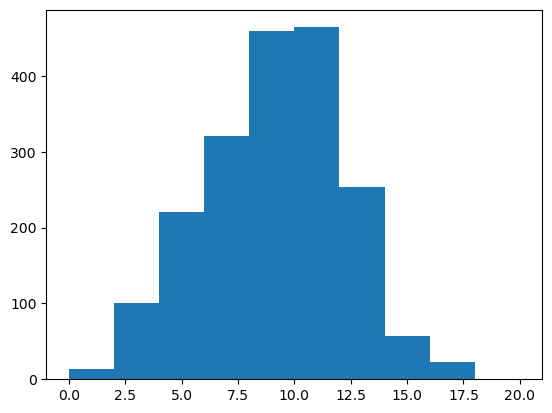

In [43]:
plt.hist(length)

The length of every sentence is between 1 and 20, hence the max size of tokens in a vector is 20

### *Transformer: Dataset Prep.*

In [44]:
transformers.__version__

'4.46.3'

In [45]:
ds = Dataset.from_pandas(df) # converts df to a pyarrow (APACHE-based) table as a dataset. This table has efficient memory utilization

In [46]:
ds

Dataset({
    features: ['sentence', 'label', '__index_level_0__'],
    num_rows: 1913
})

In [47]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the tokenizer and model from Hugging Face
model_checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=5)  # Binary classification

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
# use_fast leverages the fastest tokenizer that is backed by Rust
tok = AutoTokenizer.from_pretrained(model_checkpoint,use_fast = True)

In [49]:
# Example
tok(df['sentence'][0]) # attention_mask = 1 relates to actual word and 0 to padding

tok(ds['sentence'][0])

{'input_ids': [101, 2695, 12731, 19506, 5245, 7823, 2368, 6396, 4424, 16011, 4277, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [50]:
# max length is 512 token for bert_cased, any input sequences greater than 512 are truncated
def tokenize(examples):
    return tok(examples['sentence'],padding='longest',truncation=True)

In [51]:
encoded_ds = ds.map(tokenize,batched=True)

Map:   0%|          | 0/1913 [00:00<?, ? examples/s]

In [52]:
id2label = {0:'Sexual Harassment', 1:'Cyberstalking', 2:'Doxing', 3:'Revenge Porn', 4:'Slut Shaming'}

In [53]:
#train_ds = encoded_ds.shuffle(seed=42).select(range(1000))
#test_ds = encoded_ds.shuffle(seed=42).select(range(1000))
# dataset.map() is diff. from map(), it applies the function to all rows in 0 or more batches inplace in the background, tokenization happens in multi thread processing

# Get the dataset size
dataset_size = len(encoded_ds)

# Dynamically select a range based on the dataset size
train_ds = encoded_ds.shuffle(seed=42).select(range(min(1000, dataset_size)))
test_ds = encoded_ds.shuffle(seed=42).select(range(min(1000, dataset_size)))

# Comment explanation about dataset.map()
# dataset.map() is different from Python's built-in map(); it applies the function to all rows 
# in 0 or more batches inplace in the background. Tokenization happens using multi-threaded processing.


In [54]:
# In our dataset, 1 is toxic and 0 is non-toxic, how to deal with this- so aligned our data labels accordingly

In [55]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint,num_labels=5,id2label = id2label)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
model = model.to(device)

In [57]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


### *Transformer: Training*

In [58]:
batch_size = 16  # Define your batch size here

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # Output directory
    evaluation_strategy="epoch",     # Evaluate at the end of each epoch
    learning_rate=2e-5,              # Learning rate
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,              # Number of epochs
    weight_decay=0.01,               # Weight decay for regularization
    logging_dir='./logs',            # Directory for logging
    logging_steps=10,
)

C:\Users\USTB\anaconda3\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [59]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np
import time
import psutil
from codecarbon import EmissionsTracker

def compute_metrics(eval_pred):
    # Start tracking emissions
    tracker = EmissionsTracker()
    tracker.start()  # Start tracking emissions

    predictions, labels = eval_pred  # predictions are logits, we pass them through argmax to get classes
    predictions = np.argmax(predictions, axis=1)
    
    # Measure initial system resource usage (RAM and CPU)
    memory_before = psutil.virtual_memory().used  # Memory usage in bytes
    cpu_before = psutil.cpu_percent(interval=0.1)  # CPU usage percentage during the sleep time (quick estimate)
    
    # Calculate accuracy and F1 score
    acc_score = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')  # Use average='weighted' for multiclass
    
    # Calculate error rate (1 - accuracy)
    error_rate = 1 - acc_score
    
    # Measure inference time (in seconds)
    start_time = time.time()
    # Perform inference (you can perform batch predictions here for actual timing)
    # Since predictions are already computed, we just simulate the inference time
    end_time = time.time()
    inference_time = end_time - start_time
    
    # Measure system resource usage after computation
    memory_after = psutil.virtual_memory().used  # Memory usage in bytes after computation
    cpu_after = psutil.cpu_percent(interval=0.1)  # CPU usage percentage after computation
    
    # Calculate change in memory and CPU usage
    memory_change = memory_after - memory_before  # in bytes
    cpu_change = cpu_after - cpu_before  # in percentage
    
    # Simulate computational power estimation based on CPU usage and inference time
    computational_power_estimate = cpu_change * inference_time * 0.001  # Arbitrary scaling factor for simplicity
    
    # Convert memory usage change to MB for readability
    memory_change_mb = memory_change / (1024 * 1024)  # Convert bytes to MB
    
    # Generate classification report
    class_report = classification_report(labels, predictions, output_dict=True)  # Return report as a dictionary
    
    # Stop tracking emissions (this will also log the emissions data)
    tracker.stop()  # This will log emissions to the console or file automatically

    # Return metrics as a dictionary
    return {
        'accuracy': acc_score,
        'f1': f1,
        'error_rate': error_rate,
        'inference_time': inference_time,
        'memory_change_mb': memory_change_mb,  # in MB
        'cpu_change': cpu_change,  # in percentage
        'computational_power_estimate': computational_power_estimate,  # Arbitrary units
        'classification_report': class_report
    }

In [60]:
trainer = Trainer(
    model=model,                     # The model you're using (e.g., DistilBERT)
    args=training_args,              # Replace 'args' with 'training_args'
    train_dataset=train_ds,          # Training dataset
    eval_dataset=test_ds,            # Evaluation dataset
    compute_metrics=compute_metrics, # Metrics computation function (accuracy, f1 score)
    tokenizer=tok                    # The tokenizer (needed for padding and tokenization)
)

C:\Users\USTB\AppData\Local\Temp\ipykernel_4336\1316016884.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
[codecarbon INFO @ 09:09:40] [setup] RAM Tracking...
[codecarbon INFO @ 09:09:40] [setup] GPU Tracking...
[codecarbon INFO @ 09:09:40] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 09:09:40] [setup] CPU Tracking...
[codecarbon WARNING @ 09:09:40] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 09:09:41] We saw that you have a 13th Gen Intel(R) Core(TM) i9-13900 but we don't know it. Please contact us.
[codecarbon INFO @ 09:09:41] CPU Model on constant consumption mode: 13th Gen Intel(R) Core(TM) i9-13900
[codecarbon INFO @ 09:09:41] >>> Tracker's metadata:
[codecarbon INFO @ 09:09:41]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 09:09:41]   Python version: 3.11.5
[codecarbon INFO @ 09:09:41]   CodeCarbon versio

In [61]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: philipoadamu (philipoadamu-university-of-science-and-technology-beijing). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Error Rate,Inference Time,Memory Change Mb,Cpu Change,Computational Power Estimate,Classification Report
1,0.856400,0.745184,0.831000,0.830197,0.169000,0.000000,-0.445312,0.400000,0.000000,"{'0': {'precision': 0.7939914163090128, 'recall': 0.8726415094339622, 'f1-score': 0.8314606741573034, 'support': 212.0}, '1': {'precision': 0.8347826086956521, 'recall': 0.7111111111111111, 'f1-score': 0.768, 'support': 135.0}, '2': {'precision': 0.8402061855670103, 'recall': 0.7874396135265701, 'f1-score': 0.8129675810473815, 'support': 207.0}, '3': {'precision': 0.7772277227722773, 'recall': 0.8051282051282052, 'f1-score': 0.7909319899244333, 'support': 195.0}, '4': {'precision': 0.8984375, 'recall': 0.9163346613545816, 'f1-score': 0.9072978303747534, 'support': 251.0}, 'accuracy': 0.831, 'macro avg': {'precision': 0.8289290866687905, 'recall': 0.8185310201108861, 'f1-score': 0.8221316151007743, 'support': 1000.0}, 'weighted avg': {'precision': 0.8320117312843889, 'recall': 0.831, 'f1-score': 0.8301974456574839, 'support': 1000.0}}"
2,0.560100,0.463367,0.874000,0.873859,0.126000,0.000000,16.488281,0.000000,0.000000,"{'0': {'precision': 0.8508771929824561, 'recall': 0.9150943396226415, 'f1-score': 0.8818181818181818, 'support': 212.0}, '1': {'precision': 0.816793893129771, 'recall': 0.7925925925925926, 'f1-score': 0.8045112781954887, 'support': 135.0}, '2': {'precision': 0.8148148148148148, 'recall': 0.8502415458937198, 'f1-score': 0.8321513002364066, 'support': 207.0}, '3': {'precision': 0.9137931034482759, 'recall': 0.8153846153846154, 'f1-score': 0.8617886178861789, 'support': 195.0}, '4': {'precision': 0.9482071713147411, 'recall': 0.9482071713147411, 'f1-score': 0.9482071713147411, 'support': 251.0}, 'accuracy': 0.874, 'macro avg': {'precision': 0.8688972351380118, 'recall': 0.864304052961662, 'f1-score': 0.8656953098901994, 'support': 1000.0}, 'weighted avg': {'precision': 0.8755094623238803, 'recall': 0.874, 'f1-score': 0.8738585767385867, 'support': 1000.0}}"
3,0.482800,0.406420,0.893000,0.893040,0.107000,0.000000,-0.257812,0.000000,0.000000,"{'0': {'precision': 0.868421052631579, 'recall': 0.9339622641509434, 'f1-score': 0.9, 'support': 212.0}, '1': {'precision': 0.8235294117647058, 'recall': 0.8296296296296296, 'f1-score': 0.8265682656826568, 'support': 135.0}, '2': {'precision': 0.8682926829268293, 'recall': 0.8599033816425121, 'f1-score': 0.8640776699029126, 'support': 207.0}, '3': {'precision': 0.9027027027027027, 'recall': 0.8564102564102564, 'f1-score': 0.8789473684210526, 'support': 195.0}, '4': {'precision': 0.967479674796748, 'recall': 0.9482071713147411, 'f1-score': 0.9577464788732394, 'support': 251.0}, 'accuracy': 0.893, 'macro avg': {'precision': 0.8860851049645129, 'recall': 0.8856225406296165, 'f1-score': 0.8854679565759722, 'support': 1000.0}, 'weighted avg': {'precision': 0.8938827445129944, 'recall': 0.893, 'f1-score': 0.8930398965763499, 'support': 1000.0}}"


[codecarbon INFO @ 09:10:05] Energy consumed for RAM : 0.000050 kWh. RAM Power : 11.886009693145752 W
[codecarbon INFO @ 09:10:06] Energy consumed for all GPUs : 0.002501 kWh. Total GPU Power : 599.69 W
[codecarbon INFO @ 09:10:06] Energy consumed for all CPUs : 0.000183 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:10:06] 0.002734 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:10:15] [setup] RAM Tracking...
[codecarbon INFO @ 09:10:15] [setup] GPU Tracking...
[codecarbon INFO @ 09:10:15] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 09:10:15] [setup] CPU Tracking...
[codecarbon WARNING @ 09:10:15] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 09:10:16] We saw that you have a 13th Gen Intel(R) Core(TM) i9-13900 but we don't know it. Please contact us.
[codecarbon INFO @ 09:10:16] CPU Model on constant consumption mode: 13th Gen Intel(R) Core(TM) i9-13900
[codecarbon INFO @ 09:10:16] >>> Tracker's metadata:
[codecarbon

TrainOutput(global_step=189, training_loss=0.7916066331207436, metrics={'train_runtime': 90.8675, 'train_samples_per_second': 33.015, 'train_steps_per_second': 2.08, 'total_flos': 26391401460000.0, 'train_loss': 0.7916066331207436, 'epoch': 3.0})

In [62]:
trainer.evaluate()

[codecarbon INFO @ 09:26:24] [setup] RAM Tracking...
[codecarbon INFO @ 09:26:24] [setup] GPU Tracking...
[codecarbon INFO @ 09:26:24] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 09:26:24] [setup] CPU Tracking...
[codecarbon WARNING @ 09:26:24] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 09:26:25] We saw that you have a 13th Gen Intel(R) Core(TM) i9-13900 but we don't know it. Please contact us.
[codecarbon INFO @ 09:26:25] CPU Model on constant consumption mode: 13th Gen Intel(R) Core(TM) i9-13900
[codecarbon INFO @ 09:26:25] >>> Tracker's metadata:
[codecarbon INFO @ 09:26:25]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 09:26:25]   Python version: 3.11.5
[codecarbon INFO @ 09:26:25]   CodeCarbon version: 2.2.2
[codecarbon INFO @ 09:26:25]   Available RAM : 31.696 GB
[codecarbon INFO @ 09:26:25]   CPU count: 32
[codecarbon INFO @ 09:26:25]   CPU model: 13th Gen Intel(R) Core(TM) i9-13900
[codecarbon INFO @ 09:26:25]   

{'eval_loss': 0.4064202904701233,
 'eval_accuracy': 0.893,
 'eval_f1': 0.8930398965763499,
 'eval_error_rate': 0.10699999999999998,
 'eval_inference_time': 0.0,
 'eval_memory_change_mb': -0.15234375,
 'eval_cpu_change': -0.5,
 'eval_computational_power_estimate': -0.0,
 'eval_classification_report': {'0': {'precision': 0.868421052631579,
   'recall': 0.9339622641509434,
   'f1-score': 0.9,
   'support': 212.0},
  '1': {'precision': 0.8235294117647058,
   'recall': 0.8296296296296296,
   'f1-score': 0.8265682656826568,
   'support': 135.0},
  '2': {'precision': 0.8682926829268293,
   'recall': 0.8599033816425121,
   'f1-score': 0.8640776699029126,
   'support': 207.0},
  '3': {'precision': 0.9027027027027027,
   'recall': 0.8564102564102564,
   'f1-score': 0.8789473684210526,
   'support': 195.0},
  '4': {'precision': 0.967479674796748,
   'recall': 0.9482071713147411,
   'f1-score': 0.9577464788732394,
   'support': 251.0},
  'accuracy': 0.893,
  'macro avg': {'precision': 0.8860851049

In [63]:
import time
import psutil
from codecarbon import EmissionsTracker

# Energy Consumption Monitoring
tracker = EmissionsTracker()
tracker.start()

# Calculate the error rate (1 - accuracy)
#error_rate = 1 - results[1]  # results[1] is the accuracy
#print(f"Error Rate: {error_rate:.4f}")

# Measure initial memory usage
process = psutil.Process()
initial_memory = process.memory_info().rss / (1024 * 1024)  # Convert to MB

# Start timing inference
start_time = time.time()

# Perform evaluation using Trainer (this is the training or evaluation loop)
trainer.evaluate()

# End timing inference
end_time = time.time()
inference_time = end_time - start_time

# Measure final memory usage
final_memory = process.memory_info().rss / (1024 * 1024)  # Convert to MB
memory_usage = final_memory - initial_memory  # In MB

# Assuming CPU usage as a proxy for energy consumption (can be extended to power meters or RAPL interfaces)
cpu_usage = psutil.cpu_percent(interval=inference_time)

# Stop the emissions tracker and get energy consumption
emissions = tracker.stop()

# Print the metrics
print(f"Inference Time: {inference_time:.4f} seconds")
print(f"Memory Usage: {memory_usage:.2f} MB")
print(f"CPU Usage during Inference: {cpu_usage:.2f}%")
print(f"Energy Consumption: {emissions} kWh")

[codecarbon INFO @ 09:27:15] [setup] RAM Tracking...
[codecarbon INFO @ 09:27:15] [setup] GPU Tracking...
[codecarbon INFO @ 09:27:15] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 09:27:17] [setup] CPU Tracking...
[codecarbon WARNING @ 09:27:17] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 09:27:18] We saw that you have a 13th Gen Intel(R) Core(TM) i9-13900 but we don't know it. Please contact us.
[codecarbon INFO @ 09:27:18] CPU Model on constant consumption mode: 13th Gen Intel(R) Core(TM) i9-13900
[codecarbon INFO @ 09:27:18] >>> Tracker's metadata:
[codecarbon INFO @ 09:27:18]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 09:27:18]   Python version: 3.11.5
[codecarbon INFO @ 09:27:18]   CodeCarbon version: 2.2.2
[codecarbon INFO @ 09:27:18]   Available RAM : 31.696 GB
[codecarbon INFO @ 09:27:18]   CPU count: 32
[codecarbon INFO @ 09:27:18]   CPU model: 13th Gen Intel(R) Core(TM) i9-13900
[codecarbon INFO @ 09:27:18]   

Inference Time: 8.8777 seconds
Memory Usage: 1.27 MB
CPU Usage during Inference: 0.70%
Energy Consumption: 3.5140272874021824e-06 kWh
